# Предсказание оценки

## Построить модель регрессии, которая бы предсказывала оценку по математике (math score) на основе остальных переменных

### 1. Импортировать необходимые библиотеки (numpy, pandas, sklearn)

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 7))


<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

### 2. Загрузить датасет Student Performance.csv в pandas DataFrame


In [133]:
sp = pd.read_csv('./StudentsPerformance.csv')

sp['gender'] = sp['gender'].astype('category')
sp['race/ethnicity'] = sp['race/ethnicity'].astype('category')
sp['parental level of education'] = sp['parental level of education'].astype('category')
sp['lunch'] = sp['lunch'].astype('category')
sp['test preparation course'] = sp['test preparation course'].astype('category')

sp

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


Датасет содержит 1000 строк и 8 столбцов

### 3. Провести предварительный анализ данных


#### 3.1 Проверить типы данных и наличие пропущенных значений

In [134]:
sp.dtypes

gender                         category
race/ethnicity                 category
parental level of education    category
lunch                          category
test preparation course        category
math score                        int64
reading score                     int64
writing score                     int64
dtype: object

Датасет содержит 5 категориальных и 3 непрерывных переменных

In [135]:
sp.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Пустых значений не обнаружено

#### 3.2 Посмотреть статистическую информацию о признаках

In [136]:
sp.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Описательные статистики непрерывных переменных

In [137]:
sp.memory_usage().sum()

29936

Датасет занимает: 64132 КиБ

#### 3.3 Исследовать распределения оценок и других категориальных переменных

__Gender - пол ученика (мужской или женский)__

gender
female    518
male      482
Name: count, dtype: int64

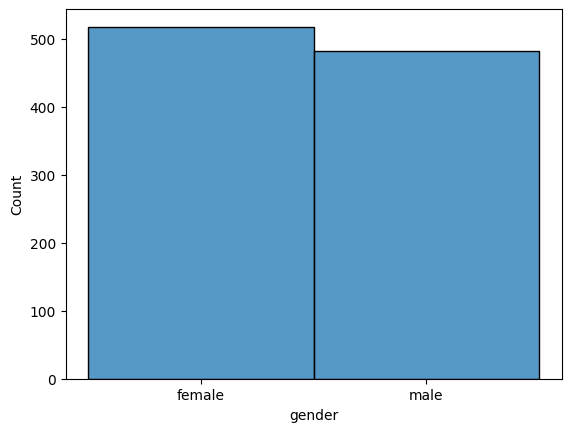

In [138]:
genders = sp['gender']
men = sp[(sp['gender'] == 'male')].shape[0] / sp.shape[0]

sns.histplot(genders)
genders.value_counts()

Гендер - бинарная категориальная переменная

Gender - бинарный признак с относительно равным распределением:

In [139]:
men_percent = int(men * 1000) / 10
print(f"{men_percent}% мужчин и {100 - men_percent}% женщин")

48.2% мужчин и 51.8% женщин


Race/ethnicity - раса/этническая принадлежность ученика

race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64

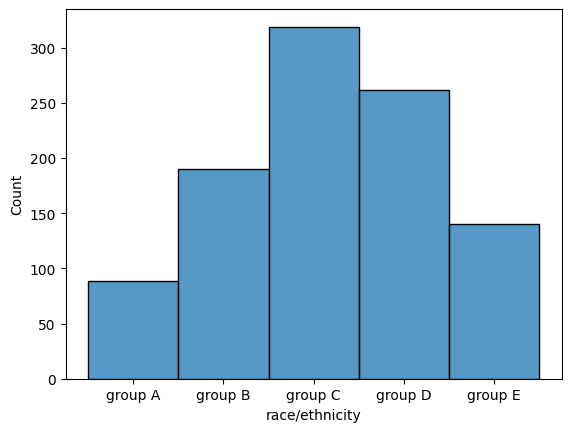

In [140]:
ethnicity = sp['race/ethnicity']

sns.histplot(ethnicity)
ethnicity.value_counts()

Всего 5 групп, где группа А - самая маленькая, а группа C самая большая

__Parental level of education - уровень образования родителей (например, высшее образование, среднее образование и т. д.)__

parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64

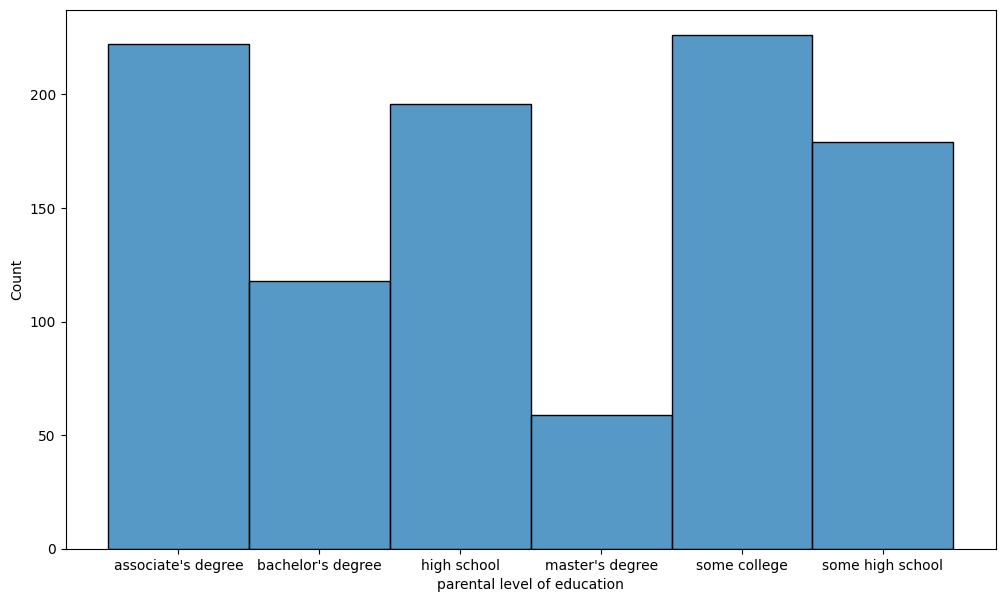

In [141]:
education_parents = sp['parental level of education']
plt.figure(figsize=(12, 7))

sns.histplot(education_parents)
education_parents.value_counts()

__Lunch - тип обеда ученика (бесплатный или платный)__

lunch
standard        645
free/reduced    355
Name: count, dtype: int64

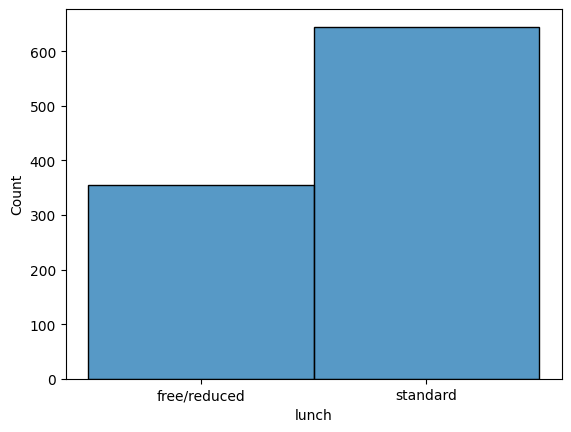

In [142]:
lunch = sp['lunch']

sns.histplot(lunch)
lunch.value_counts()

Lunch - бинарная категориальная переменная

__Test preparation course - прохождение учебных курсов подготовки к тестам (закончил или не закончил)__

test preparation course
none         642
completed    358
Name: count, dtype: int64

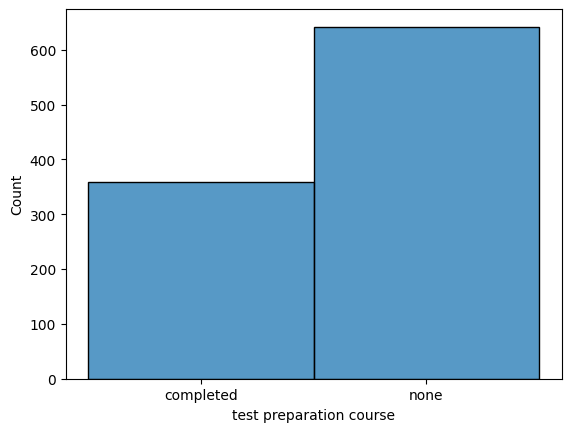

In [143]:
prep_test = sp['test preparation course']

sns.histplot(prep_test)
prep_test.value_counts()

Test preparation course - бинарная категориальная переменная

__Math score - баллы по математике__

<Axes: xlabel='math score', ylabel='Count'>

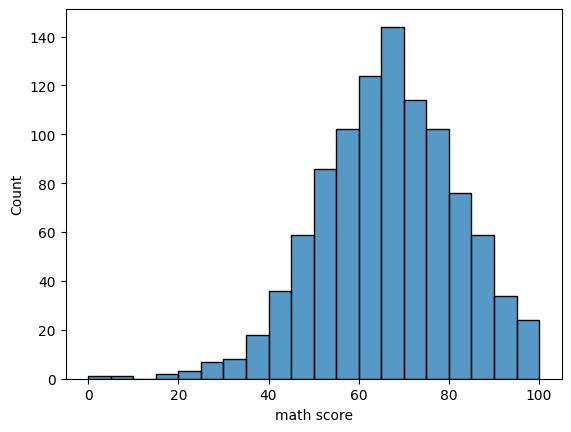

In [144]:
math_score = sp['math score']

sns.histplot(math_score, bins=20)

Распределение оценок по математике похоже на нормальное

__Reading score - баллы по чтению__

<Axes: xlabel='reading score', ylabel='Count'>

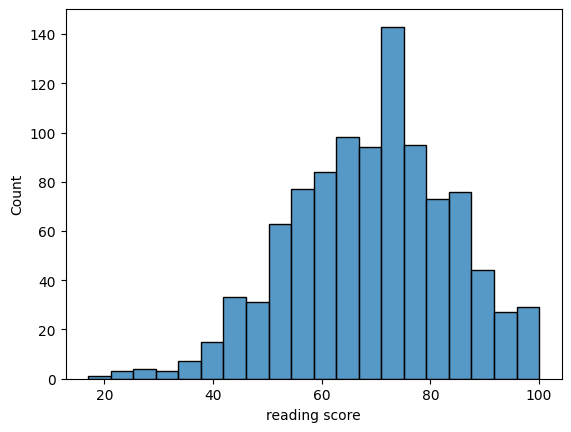

In [145]:
math_score = sp['reading score']

sns.histplot(math_score, bins=20)

Распределение балов по чтению меньше похоже на нормальное

__Writing score - баллы по письму__

<Axes: xlabel='writing score', ylabel='Count'>

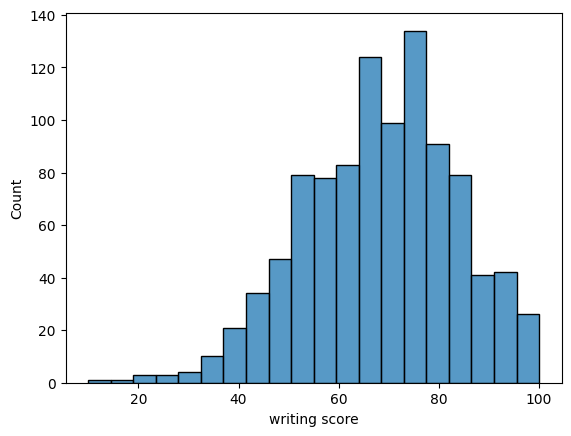

In [146]:
writing_score = sp['writing score']

sns.histplot(writing_score, bins=20)

Распределение похоже на нормальное, но хуже чем у предыдущих переменных

### 4. Подготовить данные для модели


#### 4.1 Преобразовать категориальные переменные в числовые с помощью метода one-hot encoding

In [147]:
print(genders.unique())
print(ethnicity.unique())
print(education_parents.unique())
print(lunch.unique())
print(prep_test.unique())

['female', 'male']
Categories (2, object): ['female', 'male']
['group B', 'group C', 'group A', 'group D', 'group E']
Categories (5, object): ['group A', 'group B', 'group C', 'group D', 'group E']
['bachelor's degree', 'some college', 'master's degree', 'associate's degree', 'high school', 'some high school']
Categories (6, object): ['associate's degree', 'bachelor's degree', 'high school', 'master's degree', 'some college', 'some high school']
['standard', 'free/reduced']
Categories (2, object): ['free/reduced', 'standard']
['none', 'completed']
Categories (2, object): ['completed', 'none']


gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object


In [151]:
sp_ohe = sp.copy()
sp_ohe['gender'] = sp['gender'].cat.codes

sp_ohe.dtypes

gender                             int8
race/ethnicity                 category
parental level of education    category
lunch                          category
test preparation course        category
math score                        int64
reading score                     int64
writing score                     int64
dtype: object